In [1]:
%load_ext autoreload
%autoreload 2

### 0. Sanity check trained diffusion models

In [57]:
import math
import pickle
import warnings

import torch
import matplotlib.pyplot as plt

from diff import ScoreModel2D, Scheduler
from data import PointsDataset
from ode import DDIMSolver

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore")

In [145]:
score_model = ScoreModel2D(hidden_dim=128, num_hidden=4)
score_model.load_state_dict(torch.load("best_ckpts/M_SM_410.pth"))
score_model.to(DEVICE)
score_model.eval();

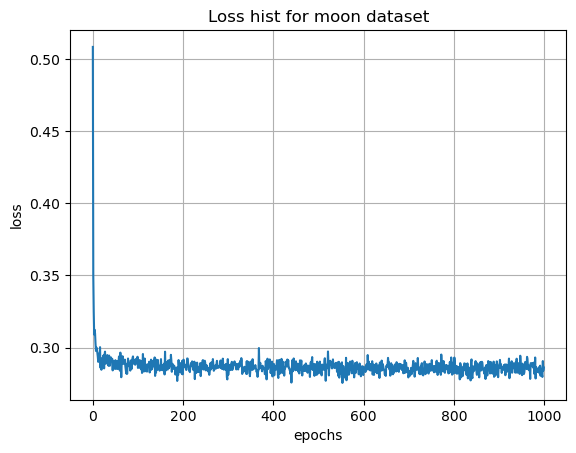

In [142]:
with open("best_ckpts/CR_SM_loss_hist.pkl", "rb") as f:
    loss_hist = pickle.load(f)

plt.plot(loss_hist)
plt.title("Loss hist for moon dataset")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1054.19it/s]


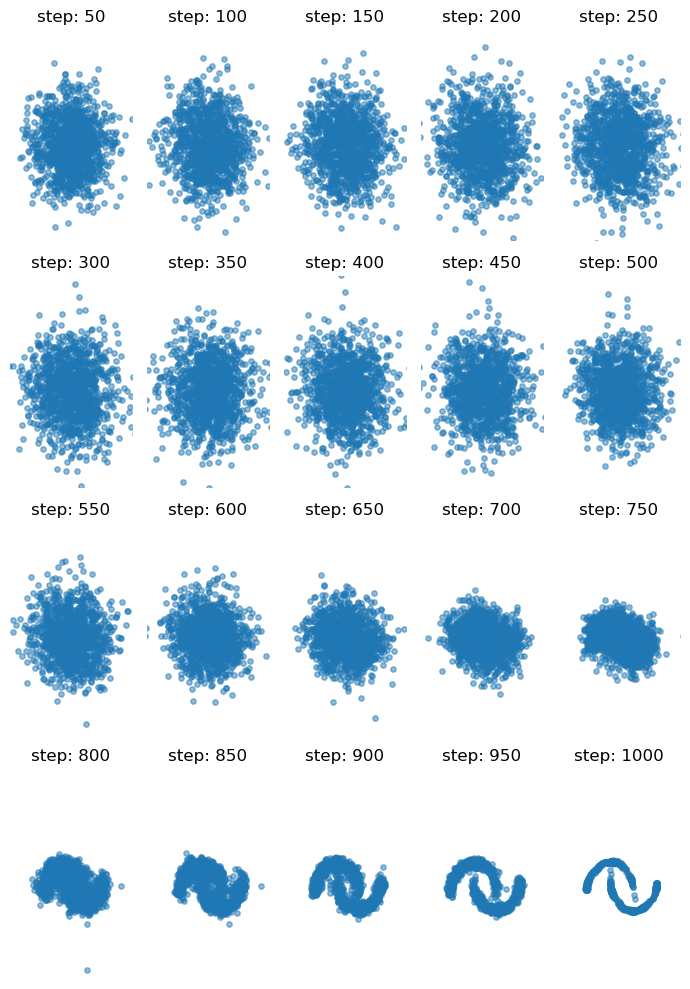

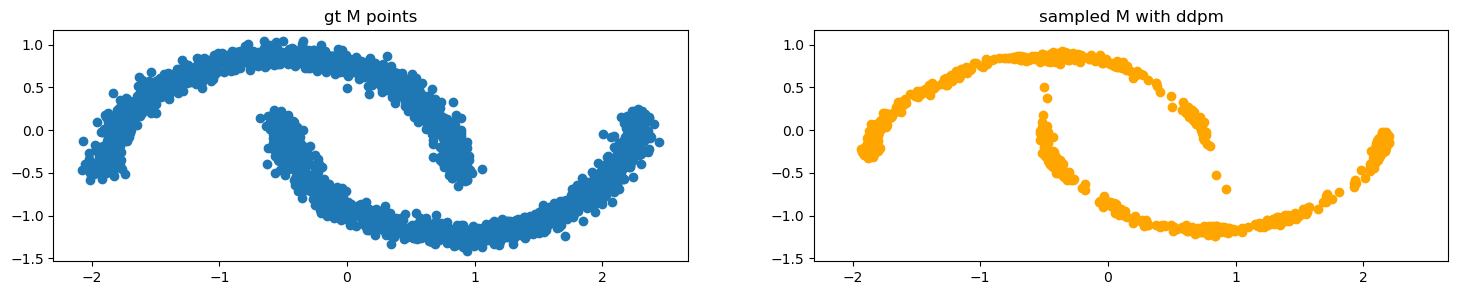

In [146]:
# sde sampling sanity check
sch = Scheduler(device=DEVICE)
sampled_points, samples = sch.sample_loop(score_model, n=12*100)
sampled_points = sampled_points.cpu().numpy()

num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(7, 10))
for i, sample in enumerate(samples):
    sample = sample.cpu().numpy()
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {(i+1)*50}")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-4., 4.75)
    plt.axis("off")
fig.tight_layout()
plt.show()

_, axs = plt.subplots(1, 2, figsize=(18, 3))
gt_points = PointsDataset(12*100, "M", torch.device("cpu")).points.numpy()

axs[0].scatter(gt_points[:, 0], gt_points[:, 1])
axs[0].set_title("gt M points")
axs[1].scatter(sampled_points[:, 0], sampled_points[:, 1], color="orange")
axs[1].set_title("sampled M with ddpm")
axs[1].set_xlim(*axs[0].get_xlim())
axs[1].set_ylim(*axs[0].get_ylim())
plt.show()

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:00<00:00, 1474.39it/s]


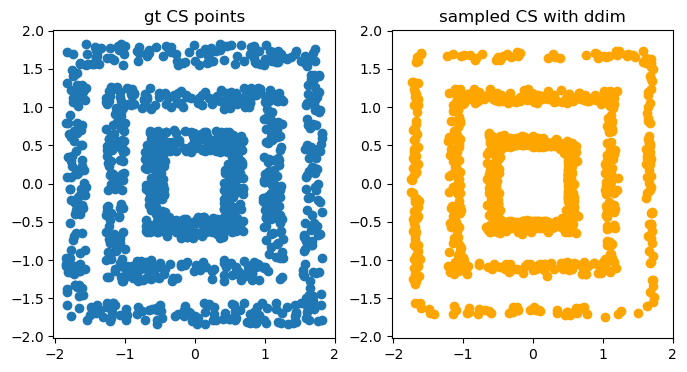

In [56]:
@torch.no_grad()
def compare_gt_and_sampled(
    ds_type: str, 
    score_model: ScoreModel2D, 
    n=500
):
    ddim_sampler = DDIMSolver(n_train_timesteps=1000, n_inference_steps=250, device=DEVICE) 

    gt_points = PointsDataset(n, ds_type, torch.device("cpu")).points.numpy()
    sampled_points = ddim_sampler.sample_loop(score_model, n=n).cpu().numpy()
    sch = Scheduler(device=DEVICE)

    _, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].scatter(gt_points[:, 0], gt_points[:, 1])
    axs[0].set_title("gt CS points")
    axs[1].scatter(sampled_points[:, 0], sampled_points[:, 1], color="orange")

    axs[1].set_title("sampled CS with ddim")
    axs[1].set_xlim(*axs[0].get_xlim())
    axs[1].set_ylim(*axs[0].get_ylim())

    plt.show()

compare_gt_and_sampled("CS", score_model, n=1200)

### 1. Replicate experiment with DDIM

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

BASE_COLORS = np.array([
    "#ff5733",
    "#138d75",
    "#a569bd",
    "#2ecc71",
    "#5d6d7e",
    "#f1c40f",
    "#a9cce3"
])

def generate_cmaps(ids, n):
    """produces cmaps around base colors"""
    if len(np.unique(ids)) > len(BASE_COLORS):
        raise ValueError
    cmaps = []
    for _ in range(len(np.unique(ids))):
        c1, c2 = BASE_COLORS[np.random.randint(0, len(BASE_COLORS), 2)]
        colors = [c1, c2]         
        cmap = LinearSegmentedColormap.from_list('CustomGradient', colors, N=n)
        cmaps.append(cmap)
    return cmaps

#### 1.2 Smooth translation

##### Same dataset MOONS

In [78]:
N=500
ds1 = PointsDataset(N, "CB", DEVICE)
x = ds1.points
ids = ds1.ids
cmap = generate_cmaps(ids, N)

sm_moons = ScoreModel2D(hidden_dim=256, num_hidden=3)
sm_moons.load_state_dict(torch.load("best_ckpts/CB_SM_650.pth"))
sm_moons.to(DEVICE)
sm_moons.eval();

ddim_sampler = DDIMSolver(n_train_timesteps=1000, n_inference_steps=50, device=DEVICE) 

In [79]:
latents = ddim_sampler.inverse_loop(sm_moons, x).detach()
x_pred = ddim_sampler.sample_loop(sm_moons, noise=latents).detach()

x = x.cpu().numpy()
latents = latents.cpu().numpy()
x_pred = x_pred.cpu().numpy()

100%|██████████| 50/50 [00:00<00:00, 1465.72it/s]


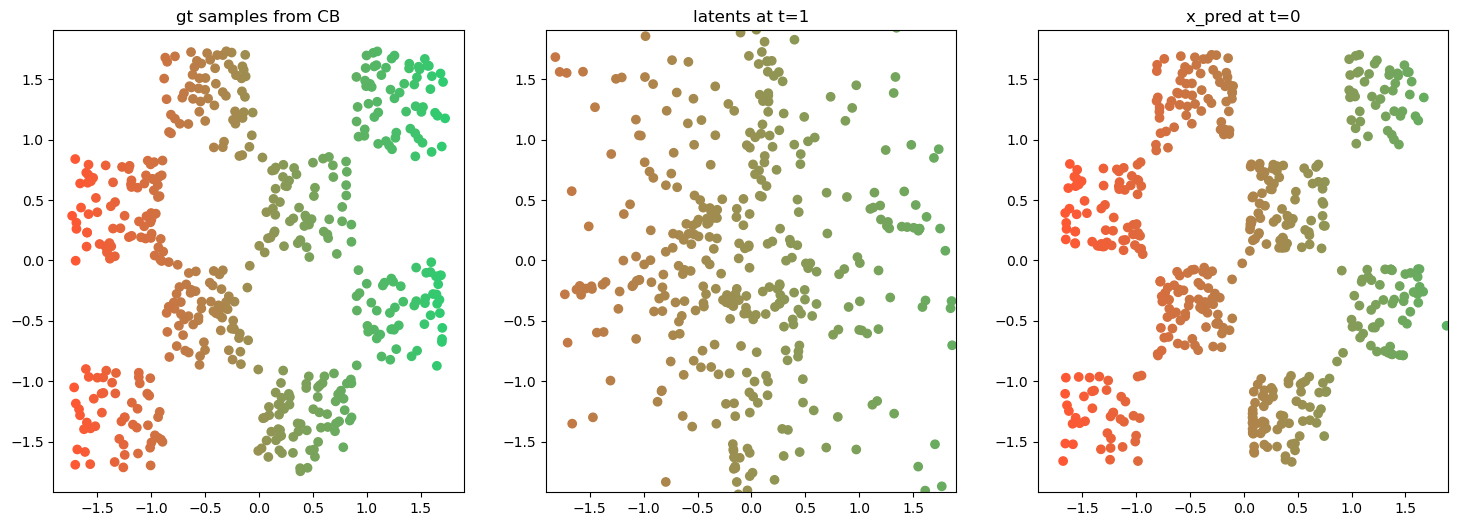

In [106]:
# visualize
cmap = generate_cmaps(ids, N)
_, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(x.shape[0] // N):
    x_i = x[i*N:(i+1)*N, :]
    axs[0].scatter(x_i[:, 0], x_i[:, 1], c=x_i[:, 0], cmap=cmap[i])
    axs[0].set_title("gt samples from CB")

for i in range(x.shape[0] // N):
    latents_i = latents[i*N:(i+1)*N, :]
    axs[1].scatter(latents_i[:, 0], latents_i[:, 1], c=latents_i[:, 0], cmap=cmap[i])
    axs[1].set_title("latents at t=1")
    axs[1].set_xlim(*axs[0].get_xlim())
    axs[1].set_ylim(*axs[0].get_ylim())

for i in range(x.shape[0] // N):
    x_pred_i = x_pred[i*N:(i+1)*N, :]
    axs[2].scatter(x_pred_i[:, 0], x_pred_i[:, 1], c=x_pred_i[:, 0], cmap=cmap[i])
    axs[2].set_title("x_pred at t=0")
    axs[2].set_xlim(*axs[0].get_xlim())
    axs[2].set_ylim(*axs[0].get_ylim())

plt.show()

##### CS and PS

In [131]:
N=1200
ds1 = PointsDataset(N, "CS", DEVICE)
ds2 = PointsDataset(N, "PS", DEVICE)
x0 = ds1.points
x1 = ds2.points
ids0 = ds1.ids
ids1 = ds2.ids


sm_cs = ScoreModel2D(hidden_dim=256, num_hidden=3)
sm_cs.load_state_dict(torch.load("best_ckpts/CS_SM_650.pth"))
sm_cs.to(DEVICE)
sm_cs.eval()

sm_ps = ScoreModel2D(hidden_dim=256, num_hidden=3)
sm_ps.load_state_dict(torch.load("best_ckpts/PS_SM_700.pth"))
sm_ps.to(DEVICE)
sm_ps.eval()

ddim_sampler = DDIMSolver(n_train_timesteps=1000, n_inference_steps=250, device=DEVICE) 

In [132]:
latents = ddim_sampler.inverse_loop(sm_cs, x0).detach()
x1_pred = ddim_sampler.sample_loop(sm_ps, noise=latents).detach()

x0 = x0.cpu().numpy()
x1 = x1.cpu().numpy()
latents = latents.cpu().numpy()
x1_pred = x1_pred.cpu().numpy()

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:00<00:00, 1496.56it/s]


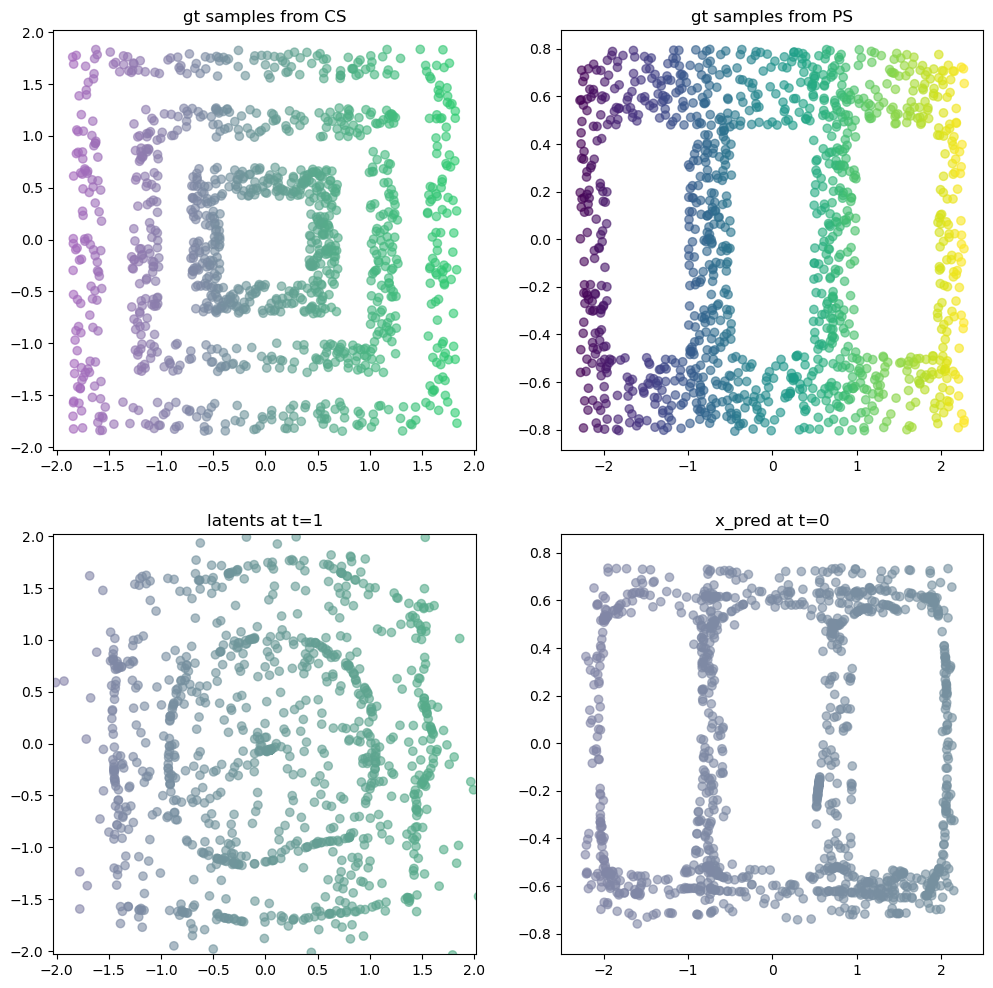

In [135]:
# visualize
_, axs = plt.subplots(2, 2, figsize=(12, 12))
cmap0 = generate_cmaps(ids0, N)

for i in range(x.shape[0] // N + 1):
    x_i = x0[i*N:(i+1)*N, :]
    axs[0, 0].scatter(x_i[:, 0], x_i[:, 1], c=x_i[:, 0], cmap=cmap0[i], alpha=0.6)
    axs[0, 0].set_title("gt samples from CS")

for i in range(x.shape[0] // N + 1):
    x_i = x1[i*N:(i+1)*N, :]
    axs[0, 1].scatter(x_i[:, 0], x_i[:, 1], c=x_i[:, 0], alpha=0.6)
    axs[0, 1].set_title("gt samples from PS")

for i in range(x.shape[0] // N + 1):
    latents_i = latents[i*N:(i+1)*N, :]
    axs[1, 0].scatter(latents_i[:, 0], latents_i[:, 1], c=latents_i[:, 0], cmap=cmap0[i], alpha=0.6)
    axs[1, 0].set_title("latents at t=1")
    axs[1, 0].set_xlim(*axs[0, 0].get_xlim())
    axs[1, 0].set_ylim(*axs[0, 0].get_ylim())

for i in range(x.shape[0] // N + 1):
    x_pred_i = x1_pred[i*N:(i+1)*N, :]
    axs[1, 1].scatter(x_pred_i[:, 0], x_pred_i[:, 1], c=x_pred_i[:, 0], cmap=cmap0[i], alpha=0.6)
    axs[1, 1].set_title("x_pred at t=0")
    axs[1, 1].set_xlim(*axs[0, 1].get_xlim())
    axs[1, 1].set_ylim(*axs[0, 1].get_ylim())

plt.show()

#### 1.2 Cycle Consistency

In [195]:
import torch

def cycle_data(x0: torch.Tensor, m1: ScoreModel2D, m2: ScoreModel2D, ddim_sampler: DDIMSolver):
    # p -> q
    latents0 = ddim_sampler.inverse_loop(m1, x0).detach()
    x1_pred = ddim_sampler.sample_loop(m2, noise=latents0).detach()
    # q -> p
    latents1 = ddim_sampler.inverse_loop(m2, x1_pred).detach()
    x0_pred = ddim_sampler.sample_loop(m1, noise=latents1).detach()

    x0 = x0.cpu().numpy()
    x1_pred = x1_pred.cpu().numpy()
    x0_pred = x0_pred.cpu().numpy()
    latents0 = latents0.cpu().numpy()
    latents1 = latents1.cpu().numpy()

    # visualize
    _, axs = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(x.shape[0] // N + 1):
        x_i = x0[i*N:(i+1)*N, :]
        axs[0, 0].scatter(x_i[:, 0], x_i[:, 1], c=x_i[:, 0], cmap=cmap0[i], alpha=0.6)
        axs[0, 0].set_title("gt samples from PS")

    for i in range(x.shape[0] // N + 1):
        x_i = latents0[i*N:(i+1)*N, :]
        axs[0, 1].scatter(x_i[:, 0], x_i[:, 1], c=x_i[:, 0], alpha=0.6)
        axs[0, 1].set_title("latents 0 -> 1")
        axs[0, 1].set_xlim(*axs[0, 0].get_xlim())
        axs[0, 1].set_ylim(*axs[0, 0].get_ylim())

    for i in range(x.shape[0] // N + 1):
        latents_i = x1_pred[i*N:(i+1)*N, :]
        axs[0, 2].scatter(latents_i[:, 0], latents_i[:, 1], c=latents_i[:, 0], cmap=cmap0[i], alpha=0.6)
        axs[0, 2].set_title("M from ddib")
        axs[0, 2].set_xlim(*axs[0, 0].get_xlim())
        axs[0, 2].set_ylim(*axs[0, 0].get_ylim())

    for i in range(x.shape[0] // N + 1):
        latents_i = latents1[i*N:(i+1)*N, :]
        axs[1, 1].scatter(latents_i[:, 0], latents_i[:, 1], c=latents_i[:, 0], cmap=cmap0[i], alpha=0.6)
        axs[1, 1].set_title("latents 1 -> 0")
        axs[1, 1].set_xlim(*axs[0, 0].get_xlim())
        axs[1, 1].set_ylim(*axs[0, 0].get_ylim())

    for i in range(x.shape[0] // N + 1):
        x_pred_i = x0_pred[i*N:(i+1)*N, :]
        axs[1, 0].scatter(x_pred_i[:, 0], x_pred_i[:, 1], c=x_pred_i[:, 0], cmap=cmap0[i], alpha=0.6)
        axs[1, 0].set_title("reconstructed PS")
        axs[1, 0].set_xlim(*axs[0, 0].get_xlim())
        axs[1, 0].set_ylim(*axs[0, 0].get_ylim())

    print(f"MSE: {np.linalg.norm(x0_pred - x1_pred, axis=1).mean():.4f}")

In [196]:
ckpts = [
    "best_ckpts/M_SM_410.pth",
    "best_ckpts/PS_SM_700.pth"
]

models = []
for ck_name in ckpts:
    if ck_name.split('/')[1].startswith("M_"):
        models.append(ScoreModel2D(hidden_dim=128, num_hidden=4)) # moons model is different
    else:
        models.append(ScoreModel2D(hidden_dim=256, num_hidden=3))
    models[-1].load_state_dict(torch.load(ck_name))
    models[-1].to(DEVICE)
    models[-1].eval()

ddim_sampler = DDIMSolver(n_train_timesteps=1000, n_inference_steps=50, device=DEVICE) 

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 1486.19it/s]


MSE: 4.1623


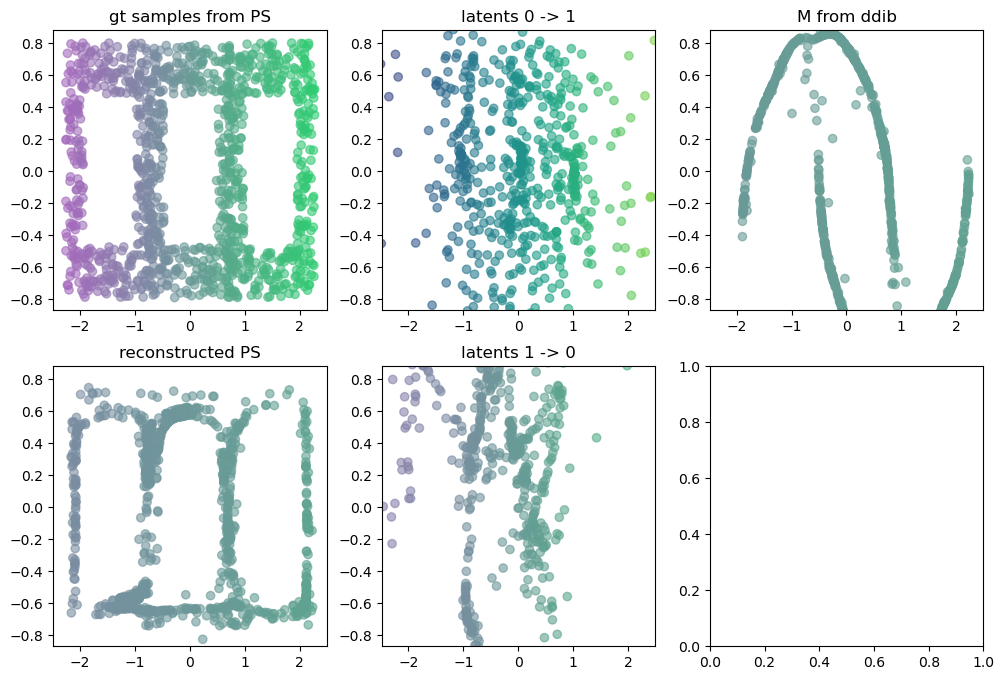

In [199]:
cycle_data(
    PointsDataset(1200, "PS", DEVICE).points,
    models[1],
    models[0],
    ddim_sampler
)